In [1]:
import numpy as np #G42

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
import pandas as pd

In [4]:
housing = pd.read_csv('Housing.csv')

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


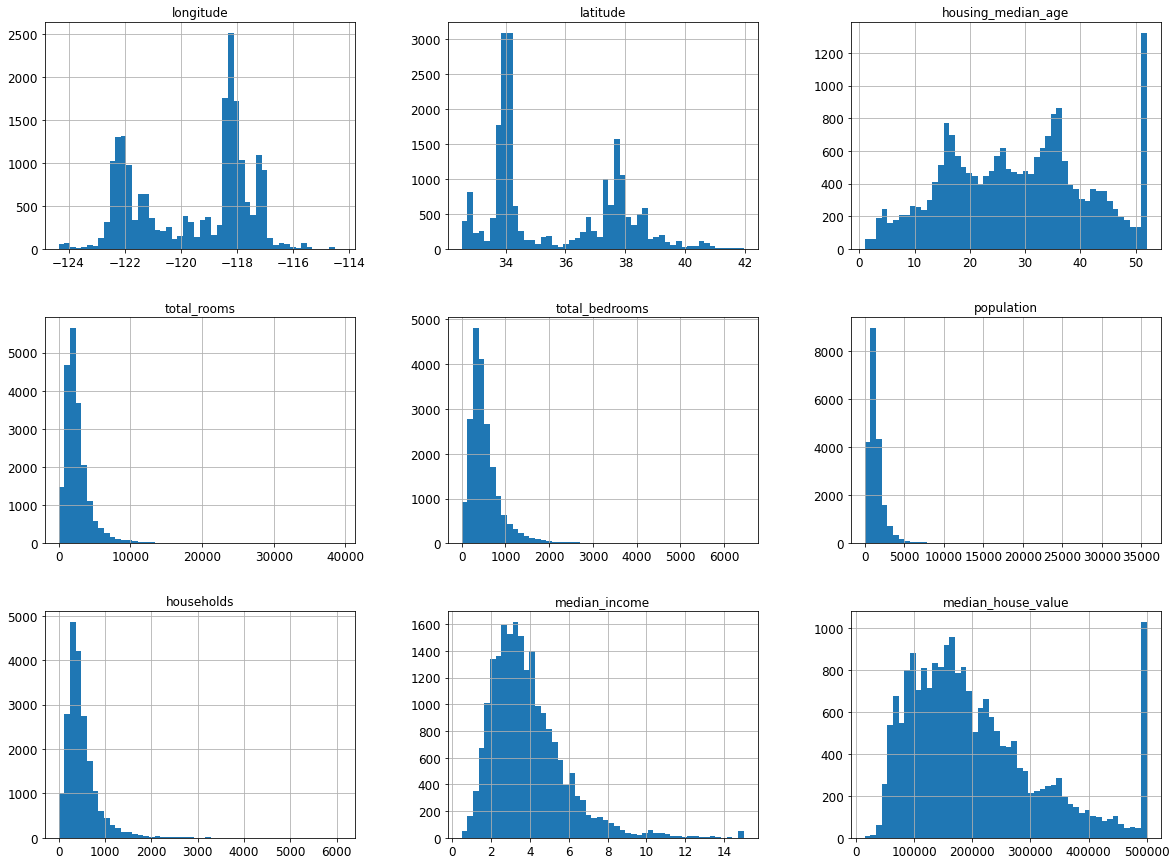

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_set, test_set = train_test_split(housing, test_size=0.2,random_state=42)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
housing = strat_train_set.copy()

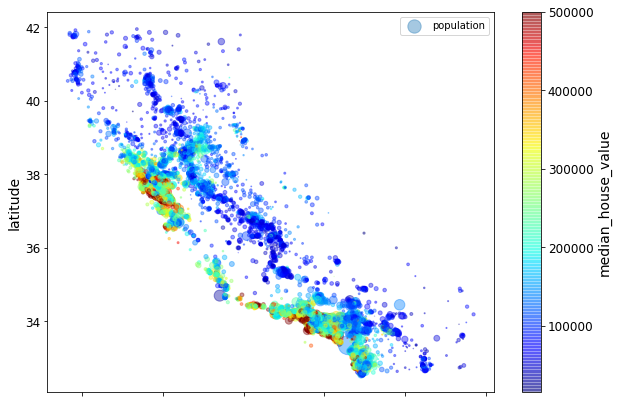

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100,label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True
)
plt.legend()

In [15]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [16]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [17]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')

In [18]:
housing_cat = housing[["ocean_proximity"]]

In [19]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [20]:
Ord_enc = OrdinalEncoder()
housing_cat_enc = Ord_enc.fit_transform(housing_cat)
#housing_cat_enc[:15]
Ord_enc.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [21]:
cat_enc = OneHotEncoder()
housing_cat_hot = cat_enc.fit_transform(housing_cat)
#type(housing_cat_hot) sparse matrix
housing_cat_hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [22]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16512 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   income_cat          16512 non-null  category
dtypes: category(1), float64(8)
memory usage: 1.1 MB


In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [24]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [27]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [28]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [29]:
some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared)) #underfit

Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039 156914.96268363 424903.23204361 228174.06586255
 140064.30950574  29195.73627083]


In [30]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0, 127900.0, 500001.0, 140200.0, 95000.0, 500001.0]


In [31]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459937

In [32]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [33]:
print("Predictions:", tree_reg.predict(some_data_prepared)) #Overfit

Predictions: [286600. 340600. 196900.  46300. 254500. 127900. 500001. 140200.  95000.
 500001.]


In [34]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_rmse)
tree_rmse

0.0

In [35]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [36]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [37]:
display_scores(tree_rmse_scores)

Scores: [70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ]
Mean: 71121.4387110585
Standard deviation: 2434.3080046605132


In [38]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)

In [39]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449331
Standard deviation: 2662.761570610342


In [40]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [41]:
print("Predictions:", forest_reg.predict(some_data_prepared))

Predictions: [263527.   331884.02 221119.    48859.   232664.   128358.   499084.98
 182379.    98169.   409274.75]


In [42]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18626.45217719628

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)